In [8]:
# load the autoreload extension
%reload_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2

import numpy as np
import joblib
import os
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

In [49]:
wp_path = '/mnt/data4/Abhishek/fidmock/wp'

wp_filenames = ['wp_subsample_'+f'{files:04d}'+'.npy' for files in range(100)]
wp = []
for files in wp_filenames:
    sample = np.load(os.path.join(wp_path,files))
    wp.append(sample[0])
wp_z = np.vstack(wp).T  
wp_filenames = ['wp_subsample_'+f'{files:04d}'+'.npy' for files in range(100,200)]
wp = []
for files in wp_filenames:
    sample = np.load(os.path.join(wp_path,files))
    wp.append(sample[0])
wp_x = np.vstack(wp).T 
wp_filenames = ['wp_subsample_'+f'{files:04d}'+'.npy' for files in range(200,300)]
wp = []
for files in wp_filenames:
    sample = np.load(os.path.join(wp_path,files))
    wp.append(sample[0])
wp_y = np.vstack(wp).T 


wpz_cov = np.cov(wp_z,bias = True)
wpx_cov = np.cov(wp_x, bias = True)
wpy_cov = np.cov(wp_y, bias = True)
wp_cov = 100*(wpz_cov + wpx_cov + wpy_cov)/3

In [50]:
filename = 'wp_model.sav'
# load the model from disk
model = joblib.load(filename)
wp_data = np.load('/mnt/data4/Abhishek/WP/wp_galaxies_0000.npy')[0]

In [51]:
wp_data

array([260.86534181, 243.32131603, 224.59096096, 204.64437357,
       184.70260426, 165.6134697 , 147.41694039, 131.29157772,
       116.21454283, 103.14360674,  91.18778846,  79.81283   ,
        68.60657022,  58.56472449,  50.02942798,  42.88834362,
        37.12308238,  32.15774451,  27.91447514,  24.26929413,
        20.97716219,  18.00164184,  15.25353038,  12.74831873,
        10.48728464,   8.45321655,   6.65530964,   5.10156874,
         3.78859548,   2.69250056])

In [52]:
def wp_model(par):
    result = model.predict(par.reshape(1,-1))
    return result[0]

In [53]:
def log_likelihood(par , data, cov):
    M_cut,M1 ,sigma, kappa, alpha = par
    diff = data - wp_model(par)
    return  -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [54]:
def log_prior(par):
    M_cut,M1 ,sigma, kappa, alpha = par
    if 12.0 < M_cut < 14.0 and 13.0 < M1 < 15.0 and 0 < sigma < 2.0 and 0 < kappa < 2.0 and 0 < alpha < 2.0:
        return 0.0
    return -np.inf

In [55]:
def log_probability(par, data, cov):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(par, data, cov)

In [13]:
x_truth = np.array([13.088658, 14.060000, 0.980000, 1.130000, 0.900000])

In [57]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = x_truth + 0.1 * np.random.randn(5)
soln = minimize(nll, initial, args=(wp_data, wp_cov))
M_cut_ml,M1_ml,sigma_ml, kappa_ml, alpha_ml = soln.x

In [58]:
soln.x

array([13.13832942, 14.04617357,  1.04476885,  1.28230299,  0.87658466])

In [73]:
init = np.array([13.09006542, 14.05997246,  0.98009625,  1.1310932,   0.90094299])
import emcee
ndim = 5
nwalkers = 64
pos = init + 1e-4 * np.random.rand(nwalkers, ndim)

with Pool() as pool:
    filename = "new_wpmcmctest.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                    args=(wp_data, wp_cov),pool=pool,backend=backend)
    #p=0
    #while(p<50):
    #    print ("Running burn-in...",p)
    #    pos, _, _ = sampler.run_mcmc(pos, 100,progress = True, store = False)
    #    sampler.reset()
    #    p += 1
    #print ("Running burn-in...")
    
    #pos, _, _ = sampler.run_mcmc(pos, 200, progress = True, store = False)
    #sampler.reset()
    print("Running production...")
    sampler.run_mcmc(pos, 1000,store=True, progress=True)


Running production...


100%|██████████| 1000/1000 [13:27<00:00,  1.17s/it]


In [74]:
print (np.median(sampler.flatchain, axis=0))

[13.09159518 14.06025187  0.98128529  1.13120687  0.89903563]


In [75]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'step number')

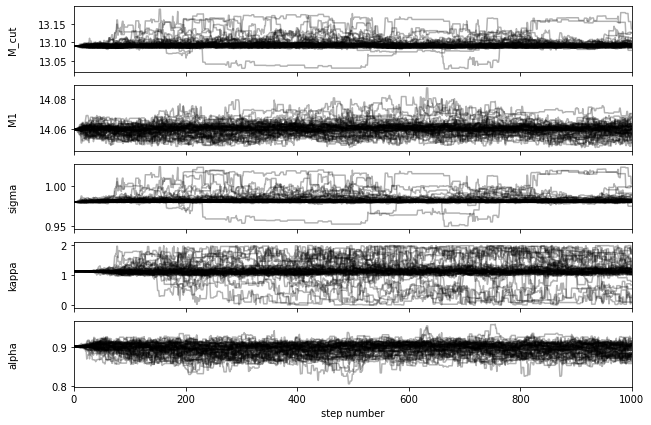

In [76]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["M_cut","M1" ,"sigma", "kappa", "alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [77]:
sampler.get_chain(discard = 100, thin = 15, flat=True)

array([[13.09086178, 14.05460583,  0.98390043,  1.05511907,  0.89601909],
       [13.09536877, 14.05995141,  0.98247922,  1.34834121,  0.88994313],
       [13.09204417, 14.06465858,  0.98016638,  1.15910425,  0.91141122],
       ...,
       [13.08894569, 14.05996419,  0.97969939,  1.19402139,  0.88121941],
       [13.09102705, 14.06175018,  0.98023872,  1.14597097,  0.90361288],
       [13.11228823, 14.05763219,  0.98915912,  1.56757701,  0.89250579]])

In [78]:
tau = sampler.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=200,thin = 15, flat=True)
print(flat_samples.shape)

(3392, 5)


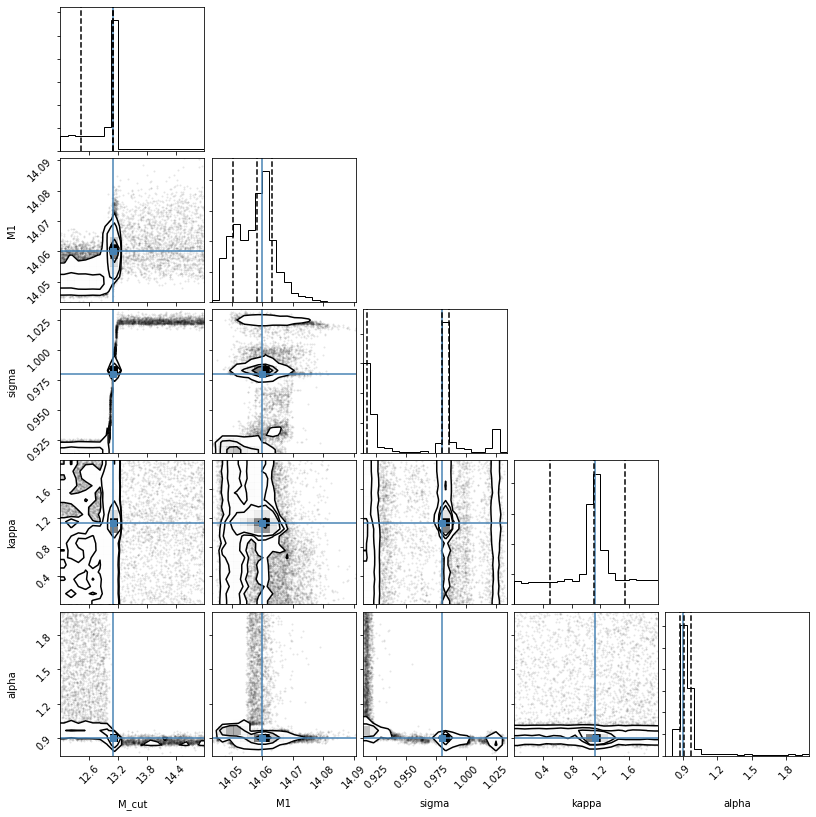

In [8]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=x_truth,quantiles=[0.16, 0.5, 0.84]
)


In [9]:
import emcee
sampler = emcee.backends.HDFBackend("wpmcmctest.h5")

In [10]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(89707840, 5)


Text(0.5, 0, 'step number')

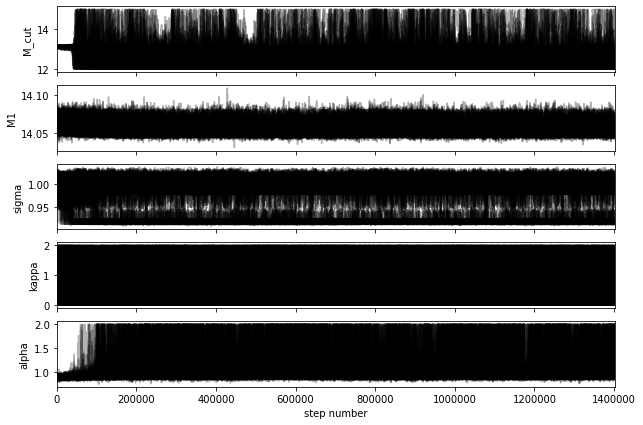

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["M_cut","M1" ,"sigma", "kappa", "alpha"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
tau = sampler.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin,thin = 15, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples,smooth = 1,color = 'k',truth_color = 'red', labels=labels,
    #range = [(13.084,13.095),(14.056,14.064),(0.9792,0.9824),(1.,1.25),(0.89,0.915)],
    truths=x_truth,quantiles=[0.16, 0.5, 0.84]
)
#plt.savefig('contourwpvpf.png')

In [19]:
from getdist import plots, MCSamples

In [20]:
wp_sample = MCSamples(samples=flat_samples,names = labels, labels=labels, label='wp_sample')

Removed no burn in


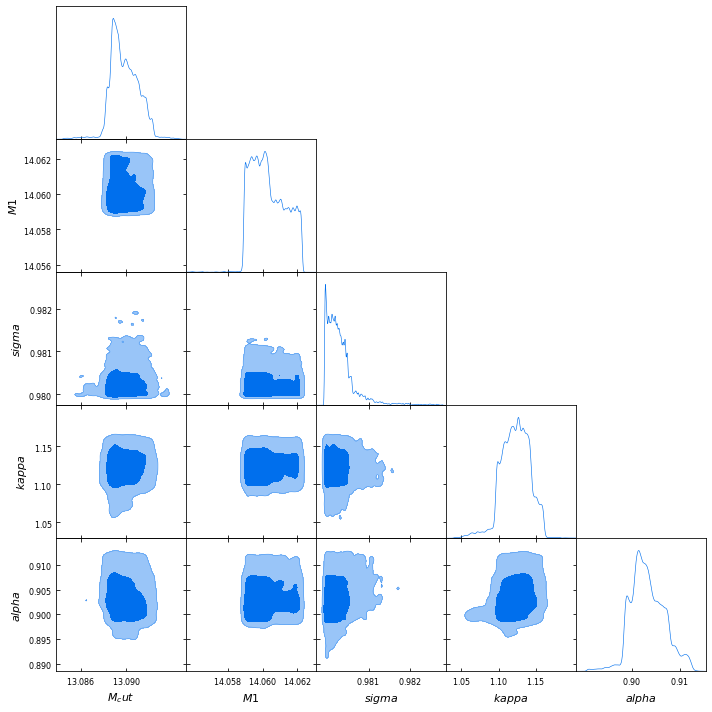

In [21]:
g = plots.get_subplot_plotter()
g.triangle_plot([wp_sample], filled=True)

((14.055038198061574, 14.060670846510517),
 (1.106846808449405, 1.1396494892437303))

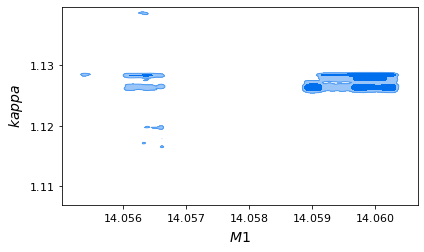

In [16]:
g = plots.get_single_plotter(width_inch=6, ratio=3 / 5.)
g.settings.legend_fontsize = 12
g.plot_2d([wp_sample], 'M1', 'kappa', filled=True)

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[ 93.86459397  95.16077831 110.98377294  79.73415306  88.68361103]


In [13]:
from IPython.display import display, Math

for i in range(5):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [81]:
x_truth

array([13.088658, 14.06    ,  0.98    ,  1.13    ,  0.9     ])

In [82]:
bins = np.logspace(-1,1.5,31)

In [173]:
bins


array([ 0.1       ,  0.12115277,  0.14677993,  0.17782794,  0.21544347,
        0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
        0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
        1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
        4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ,
       12.11527659, 14.67799268, 17.7827941 , 21.5443469 , 26.10157216,
       31.6227766 ])